In [1]:
import h5py
import numpy as np
import os
import pandas as pd
import scipy
import subprocess
import time

from os import listdir
from os.path import isfile, join

import bacco
import baccoemu

import matplotlib
from matplotlib import pyplot as plt

2024-01-04 14:41:24.268314: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-04 14:41:26.339655: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-04 14:41:26.339803: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-04 14:41:26.958192: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-04 14:41:27.597846: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-04 14:41:27.609341: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 20

#matplotlib.rc('text', usetex=True)

## Bacco setup

In [5]:
##### DEFINE QUIJOTE COSMOLOGY ############
# The cosmology is not really needed but
# bacco P(k) corrects some modes according
# to their cosmology, so better have it
# just in case

a_Quijote = 1
Ob = 0.049
Om = 0.3175
hubble = 0.6711
ns = 0.9624
sigma8 = 0.834
cosmopars = dict(
        omega_cdm=Om-Ob,
        omega_baryon=Ob, 
        hubble=hubble, 
        ns=ns, 
        sigma8=sigma8,
        #tau=0.0561,
        A_s=None,
        neutrino_mass=0.,
        w0=-1,
        wa=0,
        tag="cosmo_BOSS"
    )
    
    
cosmo_Quijote = bacco.Cosmology(**cosmopars)
cosmo_Quijote.set_expfactor(a_Quijote)

2024-01-04 14:44:28,199 bacco.cosmo :    initialization took 0.000 secs


In [6]:
ngrid = 256 #1024 #512 #256 #128 #256 #1400
#nmean=0.01 not used
BoxSize=100/hubble
print(BoxSize)

bacco.configuration.update({'pknbody' : {'ngrid'  :  ngrid}})
bacco.configuration.update({'pknbody' : {'log_binning' : True}})
bacco.configuration.update({'pknbody' : {'log_binning_kmax' : 0.99506136}})#
bacco.configuration.update({'pknbody' : {'log_binning_nbins' : 100}})
bacco.configuration.update({'pknbody' : {'min_k' : 0.01721049}})
bacco.configuration.update({'pk' : {'maxk' : 0.99506136}}) 
bacco.configuration.update({'pknbody' : {'interlacing' : True}})

bacco.configuration.update({'pknbody' : {'depmethod' : 'cic'}})

bacco.configuration.update({'nonlinear' : {'concentration' : 'ludlow16'}})

bacco.configuration.update({'number_of_threads' : 12})
bacco.configuration.update({'scaling' : {'disp_ngrid' : ngrid}})

bacco.configuration.update({'pk':{'boltzmann_solver': 'CLASS'}})

149.0090895544628


## Load SAM data from hdf5 files

In [7]:
redshift = 0
dir_dat = '/lscratch/kstoreyf/CAMELS-SAM_data'

In [8]:
#fns_dat = [join(dir_dat, f) for f in listdir(dir_dat) if isfile(join(dir_dat, f))]
idx_sam = 0
fns_dat = [f'{dir_dat}/LH_{idx_sam}_galprops_z{redshift}.hdf5']

In [9]:
n_sams = len(fns_dat)

## Load PROVABGS data

Downloaded from https://zenodo.org/records/8018936

In [10]:
# probabilistic SMFs
fn_psmf_bgs_q = '../data/data_provabgs/psmf.sv3.bgs_bright_q.z0.01_0.05.dat'
ms, psmf_bgs_q_mean, psmf_bgs_q_std = np.loadtxt(fn_psmf_bgs_q, unpack=True)

fn_psmf_bgs_sf = '../data/data_provabgs/psmf.sv3.bgs_bright_sf.z0.01_0.05.dat'
ms, psmf_bgs_sf_mean, psmf_bgs_sf_std = np.loadtxt(fn_psmf_bgs_sf, unpack=True)

In [11]:
# combine sf and q (star-forming and quiescent)
psmf_bgs_mean = psmf_bgs_sf_mean + psmf_bgs_q_mean
psmf_bgs_std = np.sqrt(psmf_bgs_sf_std**2 + psmf_bgs_q_std**2)

In [12]:
# standard (non-probabilistic) SMF, as check
fn_smf_bgs = '../data/data_provabgs/smf.standard.sv3.bgs_bright.z0.01_0.05.dat'
ms_smf, smf_bgs = np.loadtxt(fn_smf_bgs, unpack=True)

## Plot CAMELS SMFs

In [13]:
log_mass_shift = 9
h = 0.6711 # from perez et al
print(h**3)
vol_Mpc = (100/h)**3 # 100 Mpc/h = 100/h Mpc
vol_hMpc = 100**3 # units Mpc/h!! to match bgs; diff than plotted in camels paper
print(vol_Mpc, vol_hMpc)

0.302246803431
3308554.428527777 1000000


In [14]:
edges = np.linspace(8, 12.5, 40)

bin_width = edges[1] - edges[0]                
bins_avg = edges[0:-1] + bin_width/2.           

In [15]:
smf_arr = []
for i in range(n_sams):
    fn_dat = fns_dat[i]
    with h5py.File(fn_dat, 'r') as f:
        mstar_raw = np.array(f['mstar'])
        log_mstar = np.log10(mstar_raw) + log_mass_shift
        
        phi, edges = np.histogram(log_mstar, bins=edges)   
        smf = phi / vol_Mpc / bin_width
        smf_arr.append(smf)    

/tmp/ipykernel_277537/1712186730.py:6: RuntimeWarning: divide by zero encountered in log10
  log_mstar = np.log10(mstar_raw) + log_mass_shift


In [16]:
def get_distance_sigma(x1, y1, yerr1, x2, y2, xrange):
    xmin, xmax = xrange

    y1 = y1[(x1>=xmin) & (x1<xmax)]
    yerr1 = yerr1[(x1>=xmin) & (x1<xmax)]
    y2 = y2[(x2>=xmin) & (x2<xmax)]

    x1 = x1[(x1>=xmin) & (x1<xmax)]
    x2 = x2[(x2>=xmin) & (x2<xmax)]
    
    # interpolate y2 to be at the same x-vals as x2/y2
    y2_interp = np.interp(x1, x2, y2)
    sigmas = (y2_interp - y1)/yerr1
    sigma_mean = np.mean(np.abs(sigmas))
    return sigma_mean

In [17]:
sigma_means = []
xrange = [8,11]
for i in range(n_sams):
    
    sigma_mean = get_distance_sigma(ms, psmf_bgs_mean, psmf_bgs_std, bins_avg, smf_arr[i], xrange)
    sigma_means.append(sigma_mean)
sigma_means = np.array(sigma_means)

In [18]:
locs_norm = matplotlib.colors.Normalize(np.min(sigma_means), np.max(sigma_means), len(sigma_means))
cmap = matplotlib.cm.get_cmap('cool_r')
colors = cmap(locs_norm(sigma_means))

/tmp/ipykernel_277537/431812615.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('cool_r')


(8.0, 12.5)

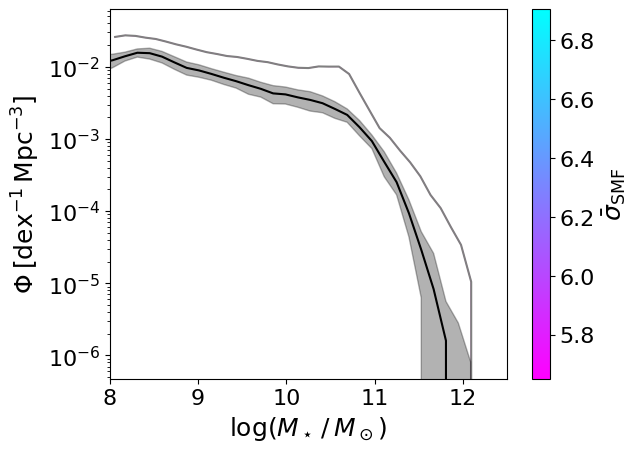

In [19]:
for i in range(n_sams):
    plt.plot(bins_avg, smf_arr[i], lw=0.7, color=colors[i])
ax = plt.gca()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
plt.colorbar(sm, ax=ax, label=r'$\bar{\sigma}_\text{SMF}$')

smf_mean = np.mean(smf_arr, axis=0)
smf_std = np.std(smf_arr, axis=0)
plt.plot(bins_avg, smf_mean, color='grey')
# plt.fill_between(bins_avg, 
#                  (smf_mean-smf_std), 
#                  (smf_mean+smf_std),
#                  color='magenta', alpha=0.3, lw=2,
#                  label='pSMF all')
    
plt.plot(ms, psmf_bgs_mean, color='black')
plt.fill_between(ms, 
                 psmf_bgs_mean-psmf_bgs_std, 
                 psmf_bgs_mean+psmf_bgs_std,
                 color='black', alpha=0.3,
                 zorder=10000,
                 label='BGS pSMF')
    
plt.yscale('log')
plt.xlabel(r'$\log(M_\star\,/\,M_\odot)$')
plt.ylabel(r'$\Phi \: [\mathrm{dex}^{-1}\, \mathrm{Mpc}^{-3}]$')
plt.xlim(8, 12.5)

## Set up bacco P(k) code

In [20]:
args_power = {'ngrid':ngrid,
                  'box':BoxSize,
                  'cosmology':cosmo_Quijote,
                  'interlacing':True,
                  'kmin':0.1,
                  'kmax':1.0,
                  'nbins':16,
                  'correct_grid':True,
                  'log_binning':False,
                  'deposit_method':'cic',
                  'compute_correlation':False,
                  'zspace':False,
                  'normalise_grid': True,
                  'compute_power2d':False}

In [21]:
import logging
logger = logging.getLogger("bacco.power")
# only log really bad events
logger.setLevel(logging.ERROR)

In [22]:
pks = []
for i in range(n_sams):
    fn_dat = fns_dat[i]
    with h5py.File(fn_dat, 'r') as f:
        x_arr, y_arr, z_arr = f['x_position'], f['y_position'], f['z_position']
        pos_arr = np.array([x_arr, y_arr, z_arr]).T
        pk = bacco.statistics.compute_powerspectrum(pos=pos_arr, **args_power)
        pks.append(pk)

2024-01-04 14:44:53,654 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-04 14:44:54,649 bacco.cosmo :    computed CLASS power spectrum at z=0.00 in 0.893 secs
2024-01-04 14:44:54,667 bacco.cosmo :    created Pk(z=0) tab from k 0.0006710999999999998 to 100000.0 h/Mpc
2024-01-04 14:44:54,674 bacco.cosmo :    computed halofit at z=0.00 for 'cosmo_BOSS' in 0.002 secs
2024-01-04 14:44:54,677 bacco.statistics :  setting the grid 256 True
2024-01-04 14:44:54,677 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2024-01-04 14:44:54,678 bacco.statistics : starting deposit 1
2024-01-04 14:44:54,744 bacco.statistics :  mesh done in 0.0667 s
2024-01-04 14:44:54,745 bacco.statistics :  Starting the power spectrum calculation
2024-01-04 14:44:54,948 bacco.statistics :  done compute.power
2024-01-04 14:44:54,949 bacco.statistics :  power done in 1.29 s


Text(0, 0.5, '$P(k)$')

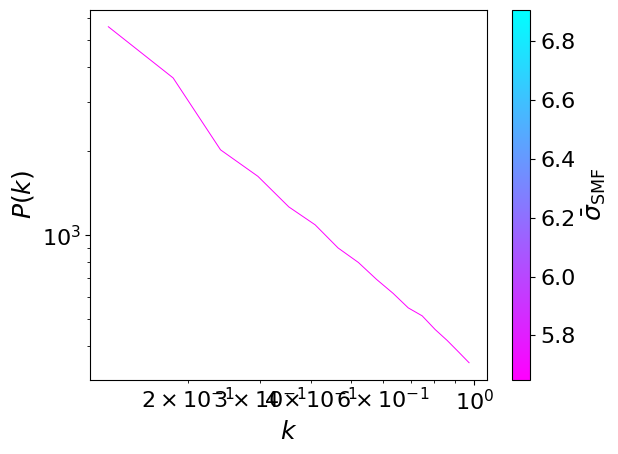

In [23]:
for i in range(n_sams):
    plt.plot(pks[i]['k'], pks[i]['pk'], lw=0.7, color=colors[i])
    
ax = plt.gca()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
plt.colorbar(sm, ax=ax, label=r'$\bar{\sigma}_\text{SMF}$')
    
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$')
plt.ylabel(r'$P(k)$')

In [24]:
k_sam_all = pks[0]['k'] # same for all 

## Load bacco emu

In [ ]:
emulator = baccoemu.Lbias_expansion()

In [ ]:
#k = np.logspace(-1.9, np.log10(emulator.emulator['nonlinear']['k'].max()), num=100)

In [ ]:
# should this match camels??
params = {
    'omega_cold'    :  Om,
    'sigma8_cold'   :  sigma8, # if A_s is not specified
    'omega_baryon'  :  Ob,
    'ns'            :  ns,
    'hubble'        :  hubble,
    'neutrino_mass' :  0.0,
    'w0'            : -1.0,
    'wa'            :  0.0,
    'expfactor'     :  1
}

In [ ]:
#k, pnn = emulator.get_nonlinear_pnn(k=k, **params)

### Fit bias params

In [ ]:
def ln_like(bias_params, k_data, p_data, C_inv):
    _, p_gg, _ = emulator.get_galaxy_real_pk(bias=bias_params, k=k_data, **params)
    delta_y = p_data - p_gg
    lnlk = 0.5 * delta_y.T @ C_inv @ delta_y
    return lnlk

In [ ]:
i_bins = k_sam_all < 0.75
k_sam = k_sam_all[i_bins]
C_inv = np.diag(np.ones(len(k_sam))/len(k_sam))

In [ ]:
bias_param_names = ['b1', 'b2', 'bs2', 'bl']
bias_param_labels = {'b1': r'$b_1$', 
                     'b2': r'$b_2$', 
                     'bs2': r'$b_{s^2}$', 
                     'bl': r'$b_{\nabla^2 \delta}$',
                    }
bias_bounds = {'b1': [-0.25, 1.75],
               'b2': [-1, 2],
               'bs2': [-3, 1],
               'bl': [-5, 2],
              } 
bounds = [bias_bounds[bname] for bname in bias_param_names]

In [ ]:
n_fit = 10

In [ ]:
bias_params_0 = [0.5, 0.5, 1.0, -1.0]
res_arr = []
for i in range(n_fit):
    print(f"Fitting SAM {i}")
    p_sam = pks[i]['pk'][i_bins]
    res = scipy.optimize.minimize(ln_like, bias_params_0, bounds=bounds, args=(k_sam, p_sam, C_inv))
    res_arr.append(res)

In [ ]:
print(np.sum([res['success'] for res in res_arr]))

In [ ]:
for i in range(n_fit):
    plt.plot(pks[i]['k'], pks[i]['pk'], lw=0.7, color=colors[i])
    _, pk_emu, _ = emulator.get_galaxy_real_pk(bias=res_arr[i]['x'], k=k_sam, **params)
    plt.plot(k_sam, pk_emu, lw=0.7, ls='--', color=colors[i])

    
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$')
plt.ylabel(r'$P(k)$')

## Plot bias params

In [ ]:
nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(5, 3*nrows), sharex=True)
plt.subplots_adjust(hspace=0)

for i in range(n_fit):
    bias_params = res_arr[i]['x']
    for bb in range(1,len(bias_param_names)):
        axarr[bb-1].plot(bias_params[0], bias_params[bb], marker='o', markersize=6, color=colors[i])
        axarr[bb-1].set_ylabel(bias_param_labels[bias_param_names[bb]])

plt.xlabel(bias_param_labels[bias_param_names[0]])